In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('nntool.py','wb').write(src)

Saving nntools.py to nntools.py


12424

In [0]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


<b>Question 1:

In [0]:
dataset_root_dir= "/content/drive/My Drive/Denoising/images"

<b>Question 2:

In [0]:
class NoisyBSDSDataset(td.Dataset):
    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)
    
    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
        format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        # COMPLETE
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
                ])
        clean = transform(clean)
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

<b>Question 3:

In [0]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [0]:
train_set = NoisyBSDSDataset(dataset_root_dir)
test_set = NoisyBSDSDataset(dataset_root_dir, mode='test', image_size=(320, 320))

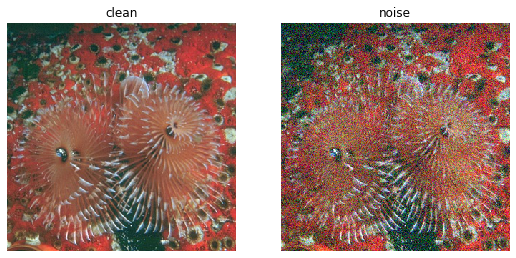

In [9]:
img = []
titles = ['clean', 'noise']

x, clean = test_set[12]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])
    
fig, axes = plt.subplots(ncols=2, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

<b>Question 4:

In [0]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

<b>Question 5:

In [0]:
class DnCNN(NNRegressor):
    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        # COMPLETE
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for k in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        # COMPLETE
        for i in range(D):
            h = self.conv[i+1](h)
            h = self.bn[i](h)
            h = F.relu(h)
        y = self.conv[D+1](h) + x
        return y

We do padding with pad_size = 1 for preserving the output size

<b>Question 6:

In [0]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_psnr = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_psnr += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        psnr = self.running_psnr / self.number_update
        return {'loss': loss, 'PSNR': psnr.cpu()}

<b>Question 7:

In [0]:
lr = 1e-3
net = DnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)

In [0]:
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="/content/drive/My Drive/Denoising/denoising1", perform_validation_during_training=True)

<b>Question 8:

In [0]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
        axes[0][0].clear()
        axes[0][1].clear()
        axes[1][0].clear()
        axes[1][1].clear()
        myimshow(noisy, ax=axes[0][0])
        axes[0][0].set_title('Noisy image')
        # COMPLETE
        myimshow(denoised, ax=axes[0][1])
        axes[0][1].set_title('Denoised image')

        axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
        axes[1][0].set_ylabel('Loss')
        axes[1][0].set_xlabel('Epoch')
        axes[1][0].legend()

        axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='average training psnr')
        axes[1][1].set_ylabel('PSNR')
        axes[1][1].set_xlabel('Epoch')
        axes[1][1].legend()
        plt.tight_layout()
        fig.canvas.draw()

Start/Continue training from epoch 200
Finish training for 200 epochs


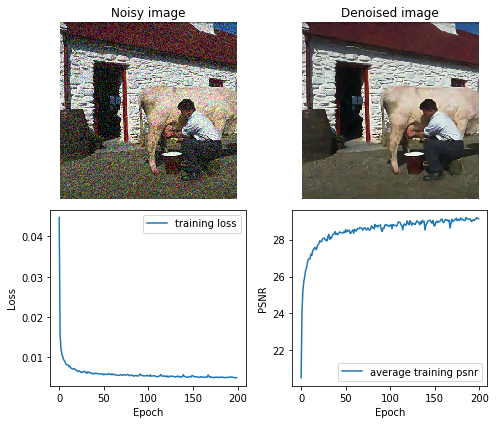

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
noisy=test_set[73][0]))

<b>Question 9:

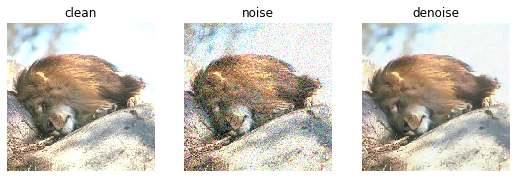

In [19]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[1]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')


Noisy image is denoised by the DnCNN and its is very clearly visible. Not much loss of information is visiable in this example as the background is uniform. We consider another example where slight loss of information is visible.

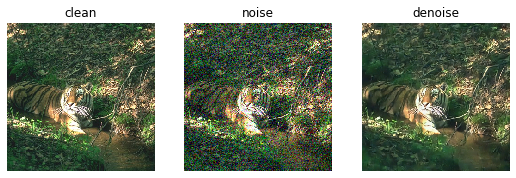

In [20]:
img = []
model = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set[5]
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

model.eval()
with torch.no_grad():
    y = model.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')


We see in the above two examples that, denoised image is successful in removing the gaussian noise from the noisy image. This might also lead in some loss of information. This tiger example is a good picture to illutrate this.

Notice the leaves in the back of the tiger, as a part of the noise removal, the leaves or atleast parts of it have also been removed. 

<b>Question 10:

In [0]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

The DnCNN (D=6) architecture has 8 convolution layers of kernel (3x3) and 6 Batch-Normalization layers. Each convolutional layer has kernel weights of each filter as features as well as a bias learnable parameter. Similarly, each Batch normalization has 2 learnable parameters.\
Therefore, total number of learnable parameters:\
First layer = 3x3x3x64 \
Middle D layers = 3x3x64x64xD \
Last layer = 3x3x64x3 \
Middle D BN layers = 2xD

For D = 6, Total parameters = 224,652

Now, regarding the receptive field. Adding a convolution layers increases the receptive field by 2 in both dimensions. Input layer has a receptive field of 1. Therefore, as there are no pooling and unpooling layers in DnCNN architecture, the receptive field at the end of the network is 1 + (2x (D+2)) = 17x17 pixels. 

<b>Question 11:

For the receptive field to be 33x33 pixels, we would be needing 1+2x(D+2) = 33, that is D = 14 for DnCNN architecture. For the number of parameters, it would have:\
First layer: 3x3x3x64 \
Middle D layers = 3x3x64x64xD \
Last layer = 3x3x64x3 \
Middle D BN layers = 2xD \

Therefore, for D=14 total parameters = 519,580. \

As the number of learnable parameters has increased, it would take more computational time to learn the optimum weights.

<b>Question 12:

In [0]:
class UDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for k in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for k in range(D)])
        

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []
        idx_buff = []
        shape_buff = []
        h_buff.append(h)
        for i in range(D//2-1):
            shape_buff.append(h.shape)
            h, idx = F.max_pool2d(F.relu(self.bn[i](self.conv[i+1](h))), 
                                  kernel_size=(2,2), return_indices=True)
            h_buff.append(h)
            idx_buff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        for i in range(D//2+1, D):
            j = i - (D//2 + 1) + 1
            h = F.relu(self.bn[i](self.conv[i+1](F.max_unpool2d( (h+h_buff[-j])/np.sqrt(2),
                                idx_buff[-j], kernel_size=(2,2), output_size=shape_buff[-j]))))
        h = self.conv[D+1]((h + h_buff[0])/np.sqrt(2))
        y = h+x
        return y

<b>Question 13:

In [0]:
net = UDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="/content/drive/My Drive/Denoising/denoising2", perform_validation_during_training=True)

Start/Continue training from epoch 200
Finish training for 200 epochs


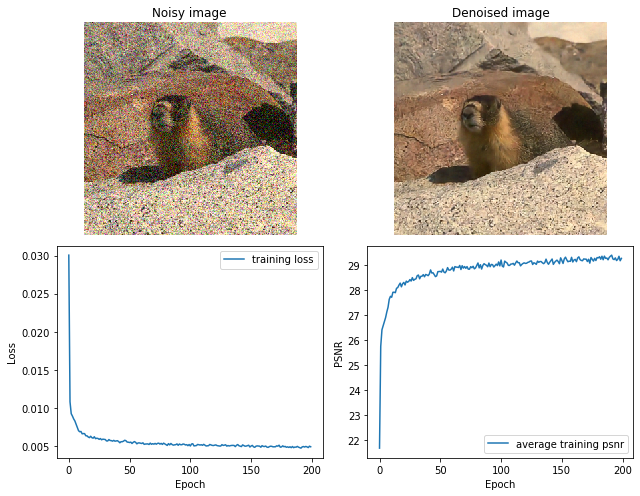

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[72][0]))

<b>Question 14:

In [25]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

Since pooling and unppooling do not have learnable parameters, the number of parameters of UDnCNN is the same as that of DnCNN. This also has: \
First layer = 3x3x3x64 \
Middle D layers = 3x3x64x64xD \
Last layer = 3x3x64x3 \
Middle D BN layers = 2xD

For D = 6, Adding Total parameters = 224,652.\

For any other value of D, we can put the value of D in the above parameter calculation and add all of them\
<b> Receptive Field </b> \
We know the receptive field next increases after each convolution by <b>2^(k−l+1) times the number you need to pad to preserve spatial resolution</b>. Here k and l are respectively the number of maxpooling and unpooling placed before that convolution. \

Regarding receptive field: \
at 1st layer = 1 \
at 2nd layer = 1+2 = 3 \
at 3rd layer = 3 + 2 = 5 \
at 4th layer = 5 +(2^2x1) = 9 \
at 5th layer = 9 +(2^3x1) = 17 \
at 6th layer = 17 + (2^3x1) = 25 \
at 7th layer = 25 + (2^2x1) = 29 \
at 8th layer = 29 + 2 = 31\
at last layer = 31 + 2 = 33 \
Therefore, total receptive field is 33x33.

We expected UDnCNN to beat DnCNN as the receptive field has increased a lot due to the pooling layers introduced in between. Also, due to more number of  skipped connections it is expected that UDnCNN learns better denoising.

<b>Question 15:

In [26]:
print('experiment 1 results:',exp1.evaluate())
print('experiment 2 results:',exp2.evaluate())

experiment 1 results: {'loss': 0.00527693978510797, 'PSNR': tensor(28.8670)}
experiment 2 results: {'loss': 0.0050498278439044956, 'PSNR': tensor(29.0717)}


Despite having much larger receptive field and greater number of skip connections than DnCNN, UDnCNN only performs a little better than DnCNN, contrary to the expectation that the results will improve by a lot. This might attriute to the fact that in the max-pooling operation there is loss of information and hence decreases the performance.

Adding extra skip connections helps the architecture to learn the mapping better and hence UDnCNN gives better performance than DnCNN.

<b>Question 16 and 17:

In [0]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for x in range(D//2, D+1)])
        l = [0 for x in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]  #Calculates the formula 2^(k-l)-1
        dilations = [i+1 for i in holes]       #dilation = holes + 1
        
        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        
        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for x in range(D)])
        

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []
        h_buff.append(h)

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        h = self.conv[D+1]((h+h_buff[0])/np.sqrt(2)) 
        y = h+x
        return y

<b>Question 18:

In [0]:
lr = 1e-3
net = DUDnCNN(6).to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(net, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="/content/drive/My Drive/Denoising/denoising3", perform_validation_during_training=True)

Start/Continue training from epoch 200
Finish training for 200 epochs


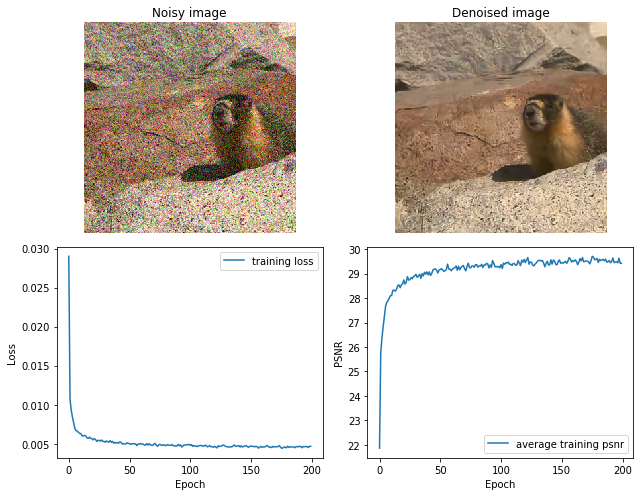

In [29]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[72][0]))

<b>Question 19:

In [30]:
print('experiment 1 results:',exp1.evaluate())
print('experiment 2 results:',exp2.evaluate())
print('experiment 3 results:',exp3.evaluate())

experiment 1 results: {'loss': 0.005317569840699434, 'PSNR': tensor(28.8294)}
experiment 2 results: {'loss': 0.005052864653989673, 'PSNR': tensor(29.0700)}
experiment 3 results: {'loss': 0.004818413145840168, 'PSNR': tensor(29.2820)}


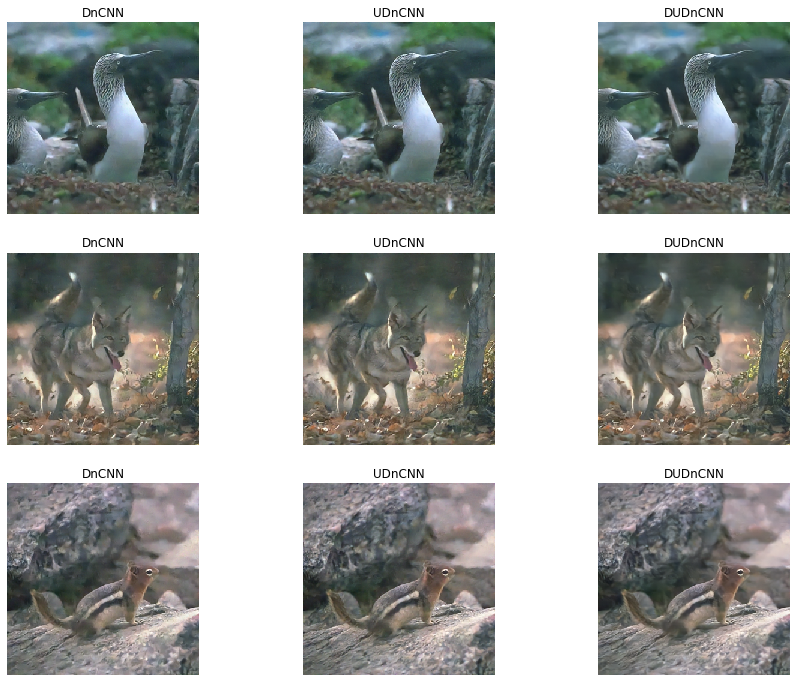

In [31]:
num = 3
img = []
nets = [exp1.net, exp2.net, exp3.net]
titles = ['DnCNN', 'UDnCNN', 'DUDnCNN']
for i in range(num):
  x, _ = test_set[2*i+7]
  x = x.unsqueeze(0).to(device)
  img.append(x)
fig, axes = plt.subplots(nrows=num, ncols=3,
figsize=(15,12), sharex='all', sharey='all')
for i in range(num):
  for j in range(len(nets)):
      model = nets[j].to(device)
      model.eval()
      with torch.no_grad():
        y = model.forward(img[i])
      myimshow(y[0], ax=axes[i][j])
      axes[i][j].set_title(f'{titles[j]}')

<b>Question 20:

In [32]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

<b>Parameters </b> \
Since dilated filters do not have extra learnable parameters, the number of parameters of DUDnCNN is the same as that of DnCNN. This also has: \
First layer = 3x3x3x64 \
Middle D layers = 3x3x64x64xD \
Last layer = 3x3x64x3 \
Middle D BN layers = 2xD

For D = 6, Total parameters = 224,652.\
For any other value of D, we can put the value of D in the above parameter calculation and add all of them\




<b> Receptive Field </b> \
We know the receptive field next increases after each convolution by <b>2^(k−l+1) times the number you need to pad to preserve spatial resolution</b>. Here k and l are respectively the number of maxpooling and unpooling placed before that convolution. Here, we in DUDnCNN we have no pooling or unpooling layers, hence k = l = 0. \

We calculate the dilations and filter dimension for each layer: \
Layer 1: dilation = 1 hence padding required = 1 \
Layer 2: dilation = 1 hence padding required = 1 \
Layer 3: dilation = 2 hence padding required = 2 \
Layer 4: dilation = 4 hence padding required = 4 \
Layer 5: dilation = 4 hence padding required = 4 \
Layer 6: dilation = 2 hence padding required = 2 \
Layer 7: dilation = 1 hence padding required = 1 \
Layer 8: dilation = 1 hence padding required = 1 \



We calculate layer by layer the increase in receptive field: \
Input: 1x1 \
Layer 1: 3x3  \
Layer 2: 5x5 \
Layer 3: 9x9 \
Layer 4: 17x17 \
Layer 5: 25x25 \
Layer 6: 29x29 \
Layer 7: 31x31 \
Layer 8: 33x33 \

Therefore, the receptive field of DUDnCNN is same as UDnCNN: 33x33


<b>Performance comparison </b> \
We see that DUDnCNN performs better than the UDnCNN. This attributes to the fact that we removed the pooling and unpooling layers which led to spatial loss and reduced performance. Instead here we use dilated convolution which both increases the receptive field preserving spatial information. Hence, it was expected that DUDnCNN would give the best results (highest PSNR) in comparison to the other two models, and this is what we observed